In [1]:
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt

### Data Prep

In [2]:
#returns
#    array of sample IDs (0-100)
#    2D array of sample SNP data 
#    array of sample positions in genome to be used as feature names
#    array of counts of samples that have SNPs in that position
def parse_SNPs(fn):
    f = open(fn)

    sample_IDs_ws = f.readline().split("\t")[2:]
    sample_IDs = [s.strip() for s in sample_IDs_ws]
    
    num_samples = len(sample_IDs)  #100
    samples = []  #SNP data for each sample
    positions = []  #positions in genome (from "catalog ID")
    counts = []
    
    for i in range(num_samples):
        samples.append([])
    
    for line in f.readlines():
        split = line.split("\t")
        positions.append(split[0])
        counts.append(split[1])
        for i, s in enumerate(split[2:]):
            samples[i].append(s.strip())
            
    return sample_IDs, samples, positions, counts

In [3]:
#returns array of labels
def parse_labels(fn):
    f = open(fn, 'r', encoding='utf-8-sig')
    labels = [None] * 100 #initializing list so sample plant_types can be added in correct positions based on ID
    
    #store plant types in positions based on sample ID
    for line in f.readlines():
        split = line.split(",")
        i = sample_IDs.index(split[0]) #sample position
        labels[i] = split[2]
    
    return labels

# Model Construction

### Shuffle, Split, and Encoding

In [4]:
sample_IDs, samples, positions, counts = parse_SNPs('SNPs.txt')
labels = parse_labels('sample_info.csv')

In [5]:
#stratified shuffle for tune/cv sets

strat_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=0)
(tune_index, cv_index) = next(strat_shuffle_split.split(samples, labels))

In [6]:
#shuffling data based on indices from stratified shuffle

#tuning set
tune_size = len(tune_index)
tune_sample_IDs = [None] * tune_size
y_tune = [None] * tune_size
X_tune = [None] * tune_size

for i, old_pos in enumerate(tune_index):
    tune_sample_IDs[i] = sample_IDs[old_pos]
    y_tune[i] = labels[old_pos]
    X_tune[i] = samples[old_pos]

#cv set
cv_size = len(cv_index)
cv_sample_IDs = [None] * cv_size
y_cv = [None] * cv_size
X_cv = [None] * cv_size

for i, old_pos in enumerate(cv_index):
    cv_sample_IDs[i] = sample_IDs[old_pos]
    y_cv[i] = labels[old_pos]
    X_cv[i] = samples[old_pos]


#complete set
X = X_cv + X_tune
y = y_cv + y_tune
sample_IDs = cv_sample_IDs + tune_sample_IDs

In [7]:
ohe = OneHotEncoder()
ohe.fit(samples)

OneHotEncoder()

In [8]:
X_encoded = ohe.transform(X).toarray()
X_cv_encoded = ohe.transform(X_cv).toarray()
X_tune_encoded = ohe.transform(X_tune).toarray()

### Tuning

In [9]:
# info on tuning from sources 1 & 2:
# increasing n_estimators and max_features improves performance, eventually plateaus
# use larger values for max_features if there are many irrelevant input variables
# too large of a max_depth can cause overfitting

In [10]:
rfc_tune = RandomForestClassifier(
                            class_weight='balanced',
                            criterion='entropy',
                            n_estimators=500,
                            max_features=0.5,
                            )

loo = LeaveOneOut()

start = time.time()
scores_tune = cross_val_score(rfc_tune, X_tune_encoded, y_tune, cv=loo)
end = time.time()
print(end-start)

print('Accuracy: %.3f, std: %.3f' % (np.mean(scores_tune), np.std(scores_tune)))

### LOOCV

In [12]:
rfc_cv = RandomForestClassifier(
                            class_weight='balanced',
                            criterion='entropy',
                            n_estimators=500,
                            max_features=0.5
                            )

loo = LeaveOneOut()

start = time.time()
scores = cross_val_score(rfc_cv, X_cv_encoded, y_cv, cv=loo)
end = time.time()
print(end-start)

print('Accuracy: %.3f, std: %.3f' % (np.mean(scores), np.std(scores)))

1764.0306582450867
Accuracy: 0.757, std: 0.429


### ROC

In [10]:
binarizer = LabelBinarizer().fit(y_cv)
y_cv_oh = binarizer.transform(y_cv)
X_train, X_test, y_train, y_test = train_test_split(X_cv_encoded, y_cv_oh, test_size=0.3, random_state=0)

In [11]:
rfc_roc = RandomForestClassifier(class_weight='balanced', criterion='entropy', n_estimators=500, max_features=0.5)
ovr = OneVsRestClassifier(rfc_roc)
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_features=0.5,
                                                     n_estimators=500))

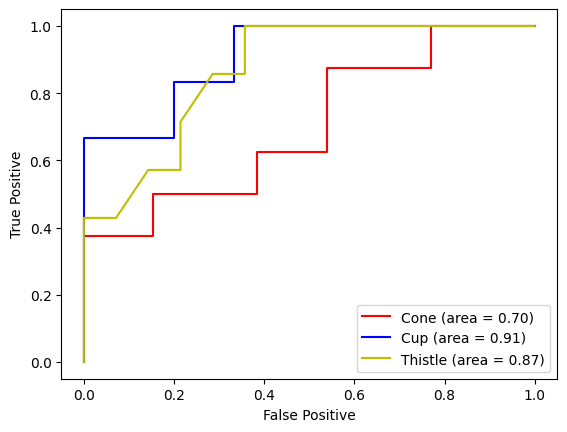

In [12]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ovr.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plt.figure()
colors = ['r', 'b', 'y']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label="{0} (area = {1:0.2f})".format(binarizer.classes_[i], roc_auc[i]))
    
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend(loc="lower right")
plt.show()

# Feature Importance Analysis

In [8]:
#takes raw SNP data and cooresponding subset of positions/loci, gets average feature importances and OOB score over 10 runs
def avg_fi_oob(samples, labels, positions_subset):
    
    #encode data inside to account for fluid data formatting
    ohe = OneHotEncoder()
    ohe.fit(samples)
    X = ohe.transform(samples).toarray()
    y = labels
    
    feature_importances = {pos: 0 for pos in positions_subset}
    avg_oob = 0
    
    #get running total of feature importances and oob scores for 10 models
    for i in range(10):
        rfc = RandomForestClassifier(
                                class_weight='balanced',
                                criterion='entropy',
                                n_estimators=500,
                                max_features=0.5,
                                oob_score=True
                                )
        rfc.fit(X, y)
        
        avg_oob += rfc.oob_score_
        
        importance_values = rfc.feature_importances_
        feat_names = ohe.get_feature_names_out(positions_subset)
        
        for i, f in enumerate(feat_names):
            split = f.split('_')
            feature_importances[split[0]] += importance_values[i]
    
    #divide by 10 for average
    for pos in feature_importances:
        feature_importances[pos] = feature_importances[pos]/10
    avg_oob = avg_oob/10
    
    return feature_importances, avg_oob

### Averaging over 10 Runs Using Entire Feature Set

In [9]:
start = time.time()
feature_importances, oob = avg_fi_oob(samples, labels, positions)
end = time.time()
print(end-start)

69.10345125198364


In [10]:
print(oob)

0.76


In [12]:
#sorting by importance
sorted_importances = sorted(feature_importances, key=feature_importances.get, reverse=True)
sorted_features = []
sorted_values = []
for p in sorted_importances:
    sorted_features.append(p)
    sorted_values.append(feature_importances[p])

### Backward Purging

In [30]:
#returns data set with features reduced according to passed set of positions
def reduce_loci(samples, original_positions, new_positions):
    reduced_samples = [None] * 100
    for i, sample in enumerate(samples):
        reduced_sample = []
        for pos in new_positions: #construct new sample using list of new positions to get the values in the old sample
            old_index = original_positions.index(pos)
            snp_value = sample[old_index]
            reduced_sample.append(snp_value)
        reduced_samples[i] = reduced_sample
    return reduced_samples

In [66]:
bp_positions = sorted_importances[:40] #starting with top ~3% of loci
#feature_set_scores = {}
max_oob = 0
max_feature_set = {}

while len(bp_positions) > 2:
    reduced_samples = reduce_loci(samples, positions, bp_positions)
    fis, oob = avg_fi_oob(reduced_samples, labels, bp_positions)

    #feature_set_scores[tuple(fis)] = oob
    if oob > max_oob:
        max_oob = oob
        max_feature_set = fis
    
    keys = list(fis.keys())
    vals = list(fis.values())
    lowest_position = keys[vals.index(min(vals))]

    bp_positions.remove(lowest_position)
    print("Removed %s; %i left" % (lowest_position, len(bp_positions)))

Removed 9094; 39 left
Removed 6236; 38 left
Removed 13327; 37 left
Removed 3833; 36 left
Removed 8742; 35 left
Removed 11493; 34 left
Removed 3672; 33 left
Removed 9914; 32 left
Removed 17365; 31 left
Removed 6237; 30 left
Removed 1356; 29 left
Removed 13329; 28 left
Removed 18044; 27 left
Removed 8682; 26 left
Removed 16833; 25 left
Removed 5544; 24 left
Removed 1554; 23 left
Removed 9371; 22 left
Removed 10584; 21 left
Removed 9087; 20 left
Removed 234; 19 left
Removed 16922; 18 left
Removed 16838; 17 left
Removed 17170; 16 left
Removed 13083; 15 left
Removed 1497; 14 left
Removed 18310; 13 left
Removed 11552; 12 left
Removed 1451; 11 left
Removed 16830; 10 left
Removed 990; 9 left
Removed 9373; 8 left
Removed 18051; 7 left
Removed 7139; 6 left
Removed 17366; 5 left
Removed 11553; 4 left
Removed 16205; 3 left
Removed 18011; 2 left


In [73]:
print(len(max_feature_set))
print(max_oob)

33
0.849


**Settled on 33 features with an average OOB score of 0.849 over 10 runs**

In [72]:
f = open("output/backward_purging_results.txt", "w")
for feat in max_feature_set:
    f.write(str(feat) + ": " + str(max_feature_set[feat]) + "\n")
f.close()

### Elbow Method

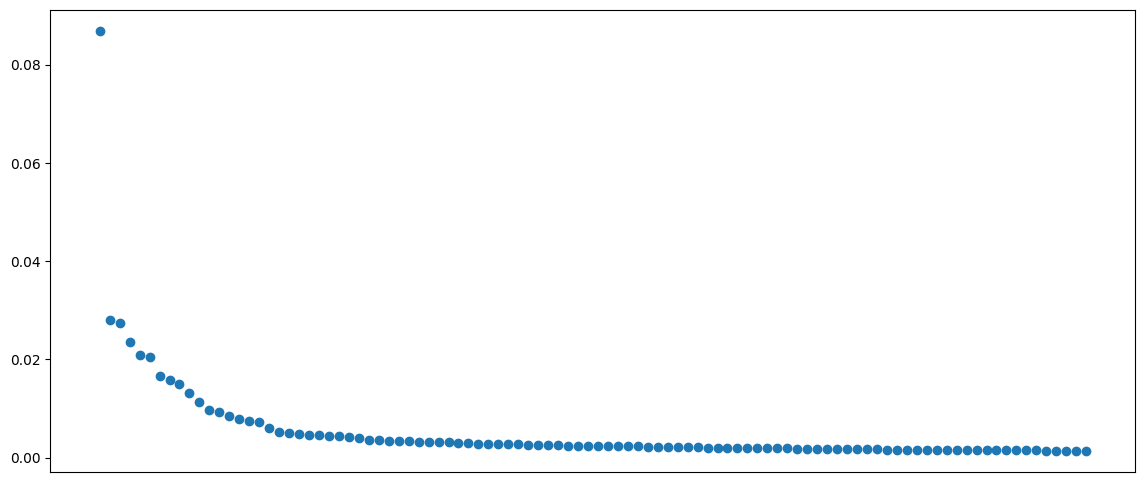

In [34]:
#elbow method -> top ~30 cutoff
plt.figure(figsize=(14,  6))
plt.plot(sorted_features[:100], sorted_values[:100], 'o')
plt.xticks([])
plt.show()

In [35]:
f = open("output/all_importances.txt", "w")
for p in sorted_importances:
    f.write(str(p) + ": " + str(avg_importances[p]) + "\n")
f.close()

### Sources

1: https://link.springer.com/chapter/10.1007/978-3-030-89010-0_15

2: https://onlinelibrary.wiley.com/doi/am-pdf/10.1111/1755-0998.12773 

3: https://bmcgenomdata.biomedcentral.com/articles/10.1186/1471-2156-11-49